In [1]:
import scipy.io as sio
from scipy import optimize
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import data_helpers
import copy
from math import sin, atan

### Classify Data Points

In [2]:
df = data_helpers.clean_data([sio.loadmat("tire_data/RunData_10inch_Cornering_Matlab_SI_Round6/B1654run22.mat")])

variable_sweeps = {"load" : {"sweep" : np.array([-250, -200, -150, -100, -50]) / 0.224809, "label" : "FZ" },
                    "camber" : {"sweep" : np.array([0, 2, 4]), "label" : "IA"},
                    "pressure" : {"sweep" : np.array([8, 10, 12, 14]) * 6.89476, "label" : "P"},
                    "velocity" : {"sweep" : np.array([15, 25, 45]) * 1.60934, "label" : "V"}}

for variable, info in variable_sweeps.items():
    temp_nearest_func = lambda x: data_helpers.get_nearest_value(info["sweep"], x)
    df[variable] = df[info["label"]].apply(temp_nearest_func)

### Count Number of Points for Each Sweep

In [3]:
for variable, info in variable_sweeps.items():
    count = df.groupby([variable])[variable].count()
    variable_sweeps[variable]["count"] = count

### Choose Most Common Sweep Variable for Each Sweep for Analysis

In [65]:
temp_df = copy.copy(df)
for variable, info in variable_sweeps.items():
    if variable != "load":
        temp_df = temp_df[temp_df[variable] == info["count"].idxmax()]

### Define Pajeka Fit Formula

In [67]:
def pajeka_lat_forc_94(X, E, C, B, D):
    x = [row["FZ"] * D * sin(C * atan(B * row["SA"] - E * (B * row["SA"] - atan(B * row["SA"])))) for _, row in X.iterrows()]
    return x

In [70]:
def pajeka_lat_forc(slip_angles, E, C, B, Sh, Sv, D):
    thetas = [(1 - E) * (x + Sh) + E / B * atan(B * (x + Sh)) for x in slip_angles]
    return [D*sin(C * atan(B * x)) + Sv for x in thetas]

In [69]:
def lateral_force2(slip_angles, A, B, C, D):
    return [A*atan(B*x+D) + C for x in slip_angles]

### Find Fit Parameters

In [56]:
output = optimize.curve_fit(pajeka_lat_forc_94, temp_df, temp_df["FY"])
print(*output[0])

0.37849796007995107 1.6402969387650528 0.14421226713755966 2.452789904167964


### Compare Fit to Raw Data

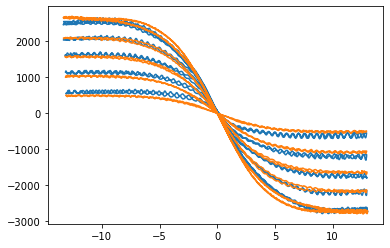

In [68]:
plt.plot(temp_df["SA"], temp_df["FY"])
plt.plot(temp_df["SA"], pajeka_lat_forc_94(temp_df, *output[0]))
plt.show()